# ÌîÑÎ°úÏ†ùÌä∏ : Pretrained model ÌôúÏö©
## üéØ Î£®Î∏åÎ¶≠ ÌèâÍ∞Ä
1. BERT pretrained modelÏùÑ ÌôúÏö©Ìïú KorQuAD Î™®Îç∏Ïù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÌïôÏäµÏù¥ ÏßÑÌñâ
2. KorQuAD InferenceÍ≤∞Í≥ºÍ∞Ä ÏõêÎûòÏùò Ï†ïÎãµÍ≥º ÎπÑÍµêÌï¥ Ïú†ÏÇ¨
3. pretrained modelÏù¥ Ìö®Í≥ºÏ†ÅÏûÑÏùÑ ÌôïÏù∏

In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Îç∞Ïù¥ÌÑ∞ Î°úÎçî

json Ìè¨Îß∑ÏúºÎ°ú Ïù¥Î£®Ïñ¥ÏßÑ Îç∞Ïù¥ÌÑ∞Ïùò Ïã§Ï†ú ÎÇ¥Ïö©ÏùÑ Í∞ÑÎã®ÌïòÍ≤å ÌôïÏù∏Ìï† Ïàò ÏûàÎäî Ìï®Ïàò

In [2]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list ÌòïÌÉúÏùò itemÏùÄ Ï≤´Î≤àÏß∏ itemÎßå Ï∂úÎ†•
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'

train dataset ÌôïÏù∏

In [4]:
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: ÍµêÌñ•Í≥°
        - answer_start: 54
      - id: 6566495-0-0
      - question: Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏Î•º ÏùΩÍ≥† Î¨¥ÏóáÏùÑ Ïì∞Í≥†Ïûê ÌñàÎäîÍ∞Ä?
    - context: 1839ÎÖÑ Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏ÏùÑ Ï≤òÏùå ÏùΩÍ≥† Í∑∏ ÎÇ¥Ïö©Ïóê ÎßàÏùåÏù¥ ÎÅåÎ†§ Ïù¥Î•º ÏÜåÏû¨Î°ú Ìï¥ÏÑú ÌïòÎÇòÏùò ÍµêÌñ•Í≥°ÏùÑ Ïì∞Î†§Îäî ÎúªÏùÑ Í∞ñÎäîÎã§. Ïù¥ ÏãúÍ∏∞ Î∞îÍ∑∏ÎÑàÎäî 1838ÎÖÑÏóê Îπõ ÎèÖÏ¥âÏúºÎ°ú ÏÇ∞Ï†ÑÏàòÏ†ÑÏùÑ Îã§ Í±≤ÏùÄ ÏÉÅÌô©Ïù¥Îùº Ï¢åÏ†àÍ≥º Ïã§ÎßùÏóê Í∞ÄÎìùÌñàÏúºÎ©∞ Î©îÌîºÏä§ÌÜ†Ìé†Î†àÏä§Î•º ÎßåÎÇòÎäî ÌååÏö∞Ïä§Ìä∏Ïùò Ïã¨Í≤ΩÏóê Í≥µÍ∞êÌñàÎã§Í≥† ÌïúÎã§. ÎòêÌïú ÌååÎ¶¨ÏóêÏÑú ÏïÑÎ∏åÎÑ§ÌÅ¨Ïùò ÏßÄÌúòÎ°ú ÌååÎ¶¨ ÏùåÏïÖÏõê Í¥ÄÌòÑÏïÖÎã®Ïù¥ Ïó∞Ï£ºÌïòÎäî Î≤†ÌÜ†Î≤§Ïùò ÍµêÌñ•Í≥° 9Î≤àÏùÑ Îì£Í≥† ÍπäÏùÄ Í∞êÎ™ÖÏùÑ Î∞õÏïòÎäîÎç∞, Ïù¥Í≤ÉÏù¥ Ïù¥Îì¨Ìï¥ 1ÏõîÏóê ÌååÏö∞Ïä§Ìä∏Ïùò ÏÑúÍ≥°ÏúºÎ°ú Ïì∞Ïó¨ÏßÑ Ïù¥ ÏûëÌíàÏóê Ï°∞Í∏àÏù¥ÎùºÎèÑ ÏòÅÌñ•ÏùÑ ÎÅºÏ≥§ÏúºÎ¶¨ÎùºÎäî Í≤ÉÏùÄ ÏùòÏã¨Ìï† Ïó¨ÏßÄÍ∞Ä ÏóÜÎã§. Ïó¨Í∏∞Ïùò 

valid dataset ÌôïÏù∏

In [5]:
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989ÎÖÑ 2Ïõî 15Ïùº
        - answer_start: 0
      - id: 6548850-0-0
      - question: ÏûÑÏ¢ÖÏÑùÏù¥ Ïó¨ÏùòÎèÑ ÎÜçÎØº Ìè≠Î†• ÏãúÏúÑÎ•º Ï£ºÎèÑÌïú ÌòêÏùòÎ°ú ÏßÄÎ™ÖÏàòÎ∞∞ Îêú ÎÇ†ÏùÄ?
    - context: 1989ÎÖÑ 2Ïõî 15Ïùº Ïó¨ÏùòÎèÑ ÎÜçÎØº Ìè≠Î†• ÏãúÏúÑÎ•º Ï£ºÎèÑÌïú ÌòêÏùò(Ìè≠Î†•ÌñâÏúÑÎì±Ï≤òÎ≤åÏóêÍ¥ÄÌïúÎ≤ïÎ•†ÏúÑÎ∞ò)ÏúºÎ°ú ÏßÄÎ™ÖÏàòÎ∞∞ÎêòÏóàÎã§. 1989ÎÖÑ 3Ïõî 12Ïùº ÏÑúÏö∏ÏßÄÎ∞©Í≤ÄÏ∞∞Ï≤≠ Í≥µÏïàÎ∂ÄÎäî ÏûÑÏ¢ÖÏÑùÏùò ÏÇ¨Ï†ÑÍµ¨ÏÜçÏòÅÏû•ÏùÑ Î∞úÎ∂ÄÎ∞õÏïòÎã§. Í∞ôÏùÄ Ìï¥ 6Ïõî 30Ïùº ÌèâÏñëÏ∂ïÏ†ÑÏóê ÏûÑÏàòÍ≤ΩÏùÑ ÎåÄÌëúÎ°ú ÌååÍ≤¨ÌïòÏó¨ Íµ≠Í∞ÄÎ≥¥ÏïàÎ≤ïÏúÑÎ∞ò ÌòêÏùòÍ∞Ä Ï∂îÍ∞ÄÎêòÏóàÎã§. Í≤ΩÏ∞∞ÏùÄ 12Ïõî 18Ïùº~20Ïùº ÏÇ¨Ïù¥ ÏÑúÏö∏ Í≤ΩÌù¨ÎåÄÌïôÍµêÏóêÏÑú ÏûÑÏ¢ÖÏÑùÏù¥ ÏÑ±Î™Ö Î∞úÌëúÎ•º Ï∂îÏßÑÌïòÍ≥† ÏûàÎã§Îäî Ï≤©Î≥¥Î•º ÏûÖÏàòÌñàÍ≥†, 12Ïõî 18Ïùº Ïò§Ï†Ñ 7Ïãú 40Î∂Ñ Í≤Ω Í∞ÄÏä§Ï¥ùÍ≥º Ï†ÑÏûêÎ¥âÏúºÎ°ú Î¨¥Ïû•Ìïú ÌäπÍ≥µÏ°∞ Î∞è ÎåÄÍ≥µÍ≥º ÏßÅÏõê 12Î™Ö Îì± 22Î™ÖÏùò ÏÇ¨Î≥µ Í≤ΩÏ∞∞ÏùÑ ÏäπÏö©Ï∞® 8ÎåÄÏóê ÎÇòÎàÑÏñ¥ Í≤ΩÌù¨ÎåÄÌï

## Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
1. ÎùÑÏñ¥Ïì∞Í∏∞ Îã®ÏúÑ Ï†ïÎ≥¥ Í¥ÄÎ¶¨ -> ÎùÑÏñ¥Ïì∞Í∏∞ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º Í¥ÄÎ¶¨ÌïúÎã§.

In [6]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [7]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

ÎùÑÏñ¥Ïì∞Í∏∞ Îã®ÏúÑÎ°ú tokenÏùÑ ÎÇòÎàà ÌõÑ word token ÏòÅÏó≠Î≥ÑÎ°ú Î≤àÌò∏Î•º Î∂ÄÏó¨ÌïúÎã§.
* word_tokens : ÎùÑÏñ¥Ïì∞Í∏∞Î°ú ÎÇòÎà†ÏßÑ ÌÜ†ÌÅ∞
* char_to_word : Î¨∏ÏûêÏùò ÏòÅÏó≠ Î≤àÌò∏

In [8]:
string1 = 'ÎÇòÎäî Ïò§Îäò ÏàúÎåÄÎ•º Î®πÏóàÎã§.'
string2 = 'ÎÇòÎäî  Ïò§Îäò ÏàúÎåÄÎ•º Î®πÏóàÎã§.'

In [9]:
word_tokens, char_to_word = _tokenize_whitespace(string1)    
word_tokens, char_to_word

(['ÎÇòÎäî', 'Ïò§Îäò', 'ÏàúÎåÄÎ•º', 'Î®πÏóàÎã§.'], [0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [10]:
word_tokens, char_to_word = _tokenize_whitespace(string2)    
word_tokens, char_to_word

(['ÎÇòÎäî', 'Ïò§Îäò', 'ÏàúÎåÄÎ•º', 'Î®πÏóàÎã§.'], [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

2. Tokenize by Vocab
Subword SegmentationÏùÑ Ïù¥Ïö©Ìï¥ Îã®Ïñ¥ ÏÇ¨Ï†ÑÏóê Ï∂îÍ∞ÄÌïúÎã§.
* Subword Segmentation : Î®πÏóàÎã§->Î®π+ÏóàÎã§ Î°ú ÎÇòÎàÑÏñ¥ Ï≤òÎ¶¨


[SentencePiece](https://github.com/google/sentencepiece) Î™®Îç∏ÏùÑ Ïù¥Ïö©Ìï¥ Ï†ÑÏ≤òÎ¶¨ ÏßÑÌñâ

In [11]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [12]:
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

True

In [13]:
print(word_tokens)

['ÎÇòÎäî', 'Ïò§Îäò', 'ÏàúÎåÄÎ•º', 'Î®πÏóàÎã§.']


In [14]:
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token

(['‚ñÅÎÇòÎäî', '‚ñÅÏò§Îäò', '‚ñÅÏàú', 'ÎåÄÎ•º', '‚ñÅÎ®πÏóàÎã§', '.'], [0, 1, 2, 4])

3. Imporve Span
Ï†ïÎãµÏóê Ìï¥ÎãπÌïòÎäî ÏßÄÎ¨∏ÏùÑ Ï†ïÌôïÌûà Ï∞æÏïÑÎÇ¥Îäî Í≤ÉÏù¥ Ï†ÑÏ≤òÎ¶¨Ïùò ÌïµÏã¨Ï†ÅÏù∏ ÏûëÏóÖÏù¥Îã§.

In [16]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

In [17]:
print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

[context]  1839ÎÖÑ Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏ÏùÑ Ï≤òÏùå ÏùΩÍ≥† Í∑∏ ÎÇ¥Ïö©Ïóê ÎßàÏùåÏù¥ ÎÅåÎ†§ Ïù¥Î•º ÏÜåÏû¨Î°ú Ìï¥ÏÑú ÌïòÎÇòÏùò ÍµêÌñ•Í≥°ÏùÑ Ïì∞Î†§Îäî ÎúªÏùÑ Í∞ñÎäîÎã§. Ïù¥ ÏãúÍ∏∞ Î∞îÍ∑∏ÎÑàÎäî 1838ÎÖÑÏóê Îπõ ÎèÖÏ¥âÏúºÎ°ú ÏÇ∞Ï†ÑÏàòÏ†ÑÏùÑ Îã§ Í±≤ÏùÄ ÏÉÅÌô©Ïù¥Îùº Ï¢åÏ†àÍ≥º Ïã§ÎßùÏóê Í∞ÄÎìùÌñàÏúºÎ©∞ Î©îÌîºÏä§ÌÜ†Ìé†Î†àÏä§Î•º ÎßåÎÇòÎäî ÌååÏö∞Ïä§Ìä∏Ïùò Ïã¨Í≤ΩÏóê Í≥µÍ∞êÌñàÎã§Í≥† ÌïúÎã§. ÎòêÌïú ÌååÎ¶¨ÏóêÏÑú ÏïÑÎ∏åÎÑ§ÌÅ¨Ïùò ÏßÄÌúòÎ°ú ÌååÎ¶¨ ÏùåÏïÖÏõê Í¥ÄÌòÑÏïÖÎã®Ïù¥ Ïó∞Ï£ºÌïòÎäî Î≤†ÌÜ†Î≤§Ïùò ÍµêÌñ•Í≥° 9Î≤àÏùÑ Îì£Í≥† ÍπäÏùÄ Í∞êÎ™ÖÏùÑ Î∞õÏïòÎäîÎç∞, Ïù¥Í≤ÉÏù¥ Ïù¥Îì¨Ìï¥ 1ÏõîÏóê ÌååÏö∞Ïä§Ìä∏Ïùò ÏÑúÍ≥°ÏúºÎ°ú Ïì∞Ïó¨ÏßÑ Ïù¥ ÏûëÌíàÏóê Ï°∞Í∏àÏù¥ÎùºÎèÑ ÏòÅÌñ•ÏùÑ ÎÅºÏ≥§ÏúºÎ¶¨ÎùºÎäî Í≤ÉÏùÄ ÏùòÏã¨Ìï† Ïó¨ÏßÄÍ∞Ä ÏóÜÎã§. Ïó¨Í∏∞Ïùò ÎùºÎã®Ï°∞ Ï°∞ÏÑ±Ïùò Í≤ΩÏö∞ÏóêÎèÑ Í∑∏Ïùò Ï†ÑÍ∏∞Ïóê Ï†ÅÌòÄ ÏûàÎäî Í≤ÉÏ≤òÎüº Îã®ÏàúÌïú Ï†ïÏã†Ï†Å ÌîºÎ°úÎÇò Ïã§ÏùòÍ∞Ä Î∞òÏòÅÎêú Í≤ÉÏù¥ ÏïÑÎãàÎùº Î≤†ÌÜ†Î≤§Ïùò Ìï©Ï∞ΩÍµêÌñ•Í≥° Ï°∞ÏÑ±Ïùò ÏòÅÌñ•ÏùÑ Î∞õÏùÄ Í≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§. Í∑∏Î†áÍ≤å ÍµêÌñ•Í≥° ÏûëÍ≥°ÏùÑ 1839ÎÖÑÎ∂ÄÌÑ∞ 40ÎÖÑÏóê Í±∏Ï

In [18]:
word_tokens, char_to_word = _tokenize_whitespace(context)
print(word_tokens[:20])
char_to_word[:20], context[:20]

['1839ÎÖÑ', 'Î∞îÍ∑∏ÎÑàÎäî', 'Í¥¥ÌÖåÏùò', 'ÌååÏö∞Ïä§Ìä∏ÏùÑ', 'Ï≤òÏùå', 'ÏùΩÍ≥†', 'Í∑∏', 'ÎÇ¥Ïö©Ïóê', 'ÎßàÏùåÏù¥', 'ÎÅåÎ†§', 'Ïù¥Î•º', 'ÏÜåÏû¨Î°ú', 'Ìï¥ÏÑú', 'ÌïòÎÇòÏùò', 'ÍµêÌñ•Í≥°ÏùÑ', 'Ïì∞Î†§Îäî', 'ÎúªÏùÑ', 'Í∞ñÎäîÎã§.', 'Ïù¥', 'ÏãúÍ∏∞']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839ÎÖÑ Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏ÏùÑ')

In [19]:
# ÎùÑÏñ¥Ïì∞Í∏∞(word) Îã®ÏúÑÎ°ú Ï™ºÍ∞úÏßÑ context(word_tokens)Î•º SubwordÎ°ú ÌÜ†ÌÅ∞ÌôîÌïú Í≤∞Í≥ºÎ•º ÏÇ¥Ìé¥Î¥ÖÎãàÎã§. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['‚ñÅ1839', 'ÎÖÑ']
2 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Îäî']
4 ['‚ñÅÍ¥¥ÌÖå', 'Ïùò']
6 ['‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', 'ÏùÑ']
9 ['‚ñÅÏ≤òÏùå']
10 ['‚ñÅÏùΩÍ≥†']
11 ['‚ñÅÍ∑∏']
12 ['‚ñÅÎÇ¥Ïö©Ïóê']
13 ['‚ñÅÎßàÏùåÏù¥']
14 ['‚ñÅÎÅåÎ†§']
15 ['‚ñÅÏù¥Î•º']
16 ['‚ñÅÏÜåÏû¨Î°ú']
17 ['‚ñÅÌï¥ÏÑú']
18 ['‚ñÅÌïòÎÇòÏùò']
19 ['‚ñÅÍµêÌñ•Í≥°', 'ÏùÑ']
21 ['‚ñÅÏì∞', 'Î†§Îäî']
23 ['‚ñÅÎúªÏùÑ']
24 ['‚ñÅÍ∞ñÎäîÎã§', '.']
26 ['‚ñÅÏù¥']
27 ['‚ñÅÏãúÍ∏∞']


In [20]:
# answer_startÏôÄ answer_endÎ°úÎ∂ÄÌÑ∞ word_startÏôÄ word_endÎ•º Íµ¨Ìï©ÎãàÎã§. 
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, 'ÍµêÌñ•Í≥°', ['ÍµêÌñ•Í≥°ÏùÑ'])

In [21]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['‚ñÅÍµêÌñ•Í≥°', 'ÏùÑ'])

contextÏóêÏÑú answerÏùò ÏúÑÏπòÎ•º Ï∞æÎäî Ìï®ÏàòÎ•º Ï†ïÏùò

In [15]:
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [22]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['‚ñÅÍµêÌñ•Í≥°']

4. Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÎ¶¨

In [23]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [24]:
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Ï†ÑÏ≤òÎ¶¨Í∞Ä ÏùòÎèÑÌïúÎåÄÎ°ú ÎêòÏóàÎäîÏßÄ ÌôïÏù∏

In [25]:
def print_file(filename, count=10):
    """
    ÌååÏùº ÎÇ¥Ïö© Ï∂úÎ†•
    :param filename: ÌååÏùº Ïù¥Î¶Ñ
    :param count: Ï∂úÎ†• ÎùºÏù∏ Ïàò
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(f"{data_dir}/korquad_train.json")

{"qa_id": "6566495-0-0", "title": "ÌååÏö∞Ïä§Ìä∏_ÏÑúÍ≥°", "question": ["‚ñÅÎ∞îÍ∑∏ÎÑà", "Îäî", "‚ñÅÍ¥¥ÌÖå", "Ïùò", "‚ñÅ", "ÌååÏö∞Ïä§Ìä∏", "Î•º", "‚ñÅÏùΩÍ≥†", "‚ñÅÎ¨¥ÏóáÏùÑ", "‚ñÅÏì∞Í≥†", "Ïûê", "‚ñÅ", "Ìñà", "Îäî", "Í∞Ä", "?"], "context": ["‚ñÅ1839", "ÎÖÑ", "‚ñÅÎ∞îÍ∑∏ÎÑà", "Îäî", "‚ñÅÍ¥¥ÌÖå", "Ïùò", "‚ñÅ", "ÌååÏö∞Ïä§Ìä∏", "ÏùÑ", "‚ñÅÏ≤òÏùå", "‚ñÅÏùΩÍ≥†", "‚ñÅÍ∑∏", "‚ñÅÎÇ¥Ïö©Ïóê", "‚ñÅÎßàÏùåÏù¥", "‚ñÅÎÅåÎ†§", "‚ñÅÏù¥Î•º", "‚ñÅÏÜåÏû¨Î°ú", "‚ñÅÌï¥ÏÑú", "‚ñÅÌïòÎÇòÏùò", "‚ñÅÍµêÌñ•Í≥°", "ÏùÑ", "‚ñÅÏì∞", "Î†§Îäî", "‚ñÅÎúªÏùÑ", "‚ñÅÍ∞ñÎäîÎã§", ".", "‚ñÅÏù¥", "‚ñÅÏãúÍ∏∞", "‚ñÅÎ∞îÍ∑∏ÎÑà", "Îäî", "‚ñÅ1838", "ÎÖÑÏóê", "‚ñÅÎπõ", "‚ñÅÎèÖ", "Ï¥â", "ÏúºÎ°ú", "‚ñÅÏÇ∞", "Ï†Ñ", "Ïàò", "Ï†ÑÏùÑ", "‚ñÅÎã§", "‚ñÅ", "Í±≤", "ÏùÄ", "‚ñÅÏÉÅÌô©Ïù¥", "Îùº", "‚ñÅÏ¢åÏ†à", "Í≥º", "‚ñÅÏã§Îßù", "Ïóê", "‚ñÅÍ∞ÄÎìù", "ÌñàÏúºÎ©∞", "‚ñÅÎ©î", "ÌîºÏä§", "ÌÜ†", "Ìé†", "Î†àÏä§", "Î•º", "‚ñÅÎßåÎÇòÎäî", "‚ñÅ", "ÌååÏö∞Ïä§Ìä∏", "Ïùò", "‚ñÅÏã¨", "Í≤ΩÏóê", "‚ñÅÍ≥µÍ∞ê", "ÌñàÎã§Í≥†", "‚ñÅÌïúÎã§", ".", "‚ñÅÎòêÌïú", "‚ñÅÌååÎ¶¨ÏóêÏÑú", "‚ñÅ

In [26]:
print_file(f"{data_dir}/korquad_dev.json")

{"qa_id": "6548850-0-0", "title": "ÏûÑÏ¢ÖÏÑù", "question": ["‚ñÅÏûÑÏ¢Ö", "ÏÑùÏù¥", "‚ñÅÏó¨ÏùòÎèÑ", "‚ñÅÎÜçÎØº", "‚ñÅÌè≠Î†•", "‚ñÅÏãúÏúÑÎ•º", "‚ñÅÏ£ºÎèÑÌïú", "‚ñÅÌòêÏùòÎ°ú", "‚ñÅÏßÄÎ™Ö", "Ïàò", "Î∞∞", "‚ñÅÎêú", "‚ñÅÎÇ†", "ÏùÄ", "?"], "context": ["‚ñÅ1989", "ÎÖÑ", "‚ñÅ2", "Ïõî", "‚ñÅ15", "Ïùº", "‚ñÅÏó¨ÏùòÎèÑ", "‚ñÅÎÜçÎØº", "‚ñÅÌè≠Î†•", "‚ñÅÏãúÏúÑÎ•º", "‚ñÅÏ£ºÎèÑÌïú", "‚ñÅÌòêÏùò", "(", "Ìè≠Î†•", "ÌñâÏúÑ", "Îì±", "Ï≤òÎ≤å", "Ïóê", "Í¥Ä", "Ìïú", "Î≤ïÎ•†", "ÏúÑÎ∞ò", ")", "ÏúºÎ°ú", "‚ñÅÏßÄÎ™Ö", "Ïàò", "Î∞∞", "ÎêòÏóàÎã§", ".", "‚ñÅ1989", "ÎÖÑ", "‚ñÅ3", "Ïõî", "‚ñÅ12", "Ïùº", "‚ñÅÏÑúÏö∏", "ÏßÄÎ∞©Í≤ÄÏ∞∞Ï≤≠", "‚ñÅÍ≥µÏïà", "Î∂ÄÎäî", "‚ñÅÏûÑÏ¢Ö", "ÏÑùÏùò", "‚ñÅÏÇ¨Ï†Ñ", "Íµ¨", "ÏÜç", "ÏòÅ", "Ïû•ÏùÑ", "‚ñÅÎ∞ú", "Î∂Ä", "Î∞õÏïòÎã§", ".", "‚ñÅÍ∞ôÏùÄ", "‚ñÅÌï¥", "‚ñÅ6", "Ïõî", "‚ñÅ30", "Ïùº", "‚ñÅÌèâÏñë", "Ï∂ï", "Ï†ÑÏóê", "‚ñÅÏûÑ", "Ïàò", "Í≤ΩÏùÑ", "‚ñÅÎåÄÌëúÎ°ú", "‚ñÅÌååÍ≤¨ÌïòÏó¨", "‚ñÅÍµ≠Í∞ÄÎ≥¥ÏïàÎ≤ï", "ÏúÑÎ∞ò", "‚ñÅÌòêÏùò", "Í∞Ä", "‚ñÅÏ∂îÍ∞ÄÎêòÏóàÎã§", ".", "‚ñÅÍ≤ΩÏ∞∞ÏùÄ", "‚ñÅ12", "Ïõî", "‚ñÅ18", "Ïùº

5. Question Î∂ÑÏÑù
Ïù¥ÏÉÅÏπòÍ∞Ä ÏûàÎäîÏßÄ Î∂ÑÏÑùÏùÑ ÌïúÎã§.

Ïö∞ÏÑ† Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïùò question Í∏∏Ïù¥ Î∂ÑÌè¨Î•º ÏãúÍ∞ÅÌôî

In [27]:
questions = []
contexts = []
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

19 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Îäî', '‚ñÅÍ¥¥ÌÖå', 'Ïùò', '‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', 'Î•º', '‚ñÅÏùΩÍ≥†', '‚ñÅÎ¨¥ÏóáÏùÑ', '‚ñÅÏì∞Í≥†', 'Ïûê', '‚ñÅ', 'Ìñà', 'Îäî', 'Í∞Ä', '?']
168 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Îäî', '‚ñÅÍµêÌñ•Í≥°', '‚ñÅÏûëÍ≥°', 'ÏùÑ', '‚ñÅÏñ¥Îîî', 'ÍπåÏßÄ', '‚ñÅÏì¥', '‚ñÅÎí§Ïóê', '‚ñÅÏ§ëÎã®', 'Ìñà', 'Îäî', 'Í∞Ä', '?']
80 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Í∞Ä', '‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', '‚ñÅÏÑú', 'Í≥°ÏùÑ', '‚ñÅÏì∏', '‚ñÅÎïå', '‚ñÅÏñ¥Îñ§', '‚ñÅÍ≥°', 'Ïùò', '‚ñÅÏòÅÌñ•ÏùÑ', '‚ñÅÎ∞õÏïò', 'Îäî', 'Í∞Ä', '?']
6 ['‚ñÅ1839', 'ÎÖÑ', '‚ñÅÎ∞îÍ∑∏ÎÑà', 'Í∞Ä', '‚ñÅÍµêÌñ•Í≥°', 'Ïùò', '‚ñÅÏÜåÏû¨Î°ú', '‚ñÅÏì∞', 'Î†§Í≥†', '‚ñÅÌñàÎçò', '‚ñÅÏ±ÖÏùÄ', '?']
143 ['‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', '‚ñÅÏÑú', 'Í≥°', 'Ïùò', '‚ñÅÎùº', 'Îã®', 'Ï°∞', '‚ñÅÏ°∞ÏÑ±', 'Ïù¥', '‚ñÅÏòÅÌñ•ÏùÑ', '‚ñÅÎ∞õÏùÄ', '‚ñÅÎ≤†ÌÜ†Î≤§', 'Ïùò', '‚ñÅÍ≥°ÏùÄ', '?']
0 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Í∞Ä', '‚ñÅ', 'ÌååÏö∞Ïä§Ìä∏', 'Î•º', '‚ñÅÏ≤òÏùåÏúºÎ°ú', '‚ñÅÏùΩ', 'ÏùÄ', '‚ñÅ', 'ÎÖÑ', 'ÎèÑ', 'Îäî', '?']
165 ['‚ñÅÎ∞îÍ∑∏ÎÑà', 'Í∞Ä', '‚ñÅÏ≤òÏùå', '‚ñÅÍµêÌñ•Í≥°', '‚ñÅÏûëÍ≥°', 'ÏùÑ', '‚ñÅÌïú', '‚ñÅÏû•ÏÜå',

In [28]:
train_question_counts = [len(question) for question in questions]

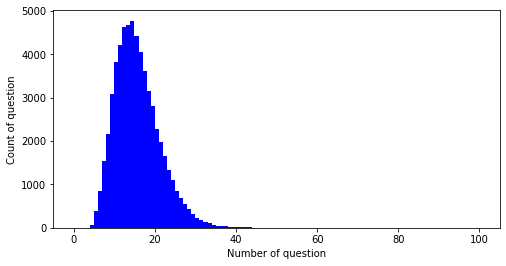

In [29]:
plt.figure(figsize=(8, 4))
plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
plt.xlabel('Number of question')
plt.ylabel('Count of question')
plt.show()

dataÏóê ÎåÄÌïú ÏÑ§Î™ÖÏùÑ Ìï¥Ï£ºÎäî Ìï®Ïàò

In [33]:
def describe(title, data):    
    print(f"{title} Í∏∏Ïù¥ ÏµúÎåÄ:    {np.max(data):4d}")
    print(f"{title} Í∏∏Ïù¥ ÏµúÏÜå:    {np.min(data):4d}")
    print(f"{title} Í∏∏Ïù¥ ÌèâÍ∑†:    {np.mean(data):7.2f}")
    print(f"{title} Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®: {np.std(data):7.2f}")    
    percentile25 = np.percentile(data, 25)
    percentile50 = np.percentile(data, 50)
    percentile75 = np.percentile(data, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    print(f"{title} 25/100Î∂ÑÏúÑ:  {percentile25:7.2f}")
    print(f"{title} 50/100Î∂ÑÏúÑ:  {percentile50:7.2f}")
    print(f"{title} 75/100Î∂ÑÏúÑ:  {percentile75:7.2f}")
    print(f"{title} IQR:        {percentileIQR:7.2f}")
    print(f"{title} MAX/100Î∂ÑÏúÑ: {percentileMAX:7.2f}")

In [34]:
describe("question", train_question_counts)

question Í∏∏Ïù¥ ÏµúÎåÄ:      58
question Í∏∏Ïù¥ ÏµúÏÜå:       3
question Í∏∏Ïù¥ ÌèâÍ∑†:      15.25
question Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®:    5.50
question 25/100Î∂ÑÏúÑ:    11.00
question 50/100Î∂ÑÏúÑ:    14.00
question 75/100Î∂ÑÏúÑ:    18.00
question IQR:           7.00
question MAX/100Î∂ÑÏúÑ:   28.50


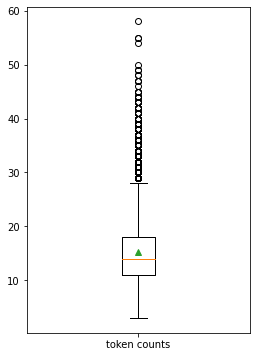

In [32]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True)
plt.show()

6. context Î∂ÑÏÑù

In [35]:
train_context_counts = [len(context) for context in contexts]

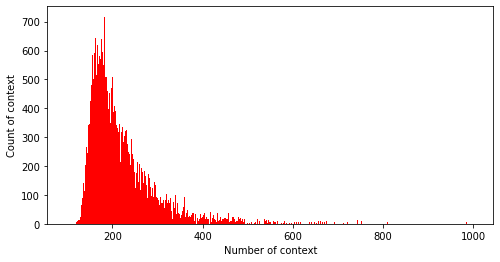

In [37]:
plt.figure(figsize=(8, 4))
plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
plt.xlabel('Number of context')
plt.ylabel('Count of context')
plt.show()

In [38]:
describe("context", train_context_counts)

context Í∏∏Ïù¥ ÏµúÎåÄ:    4816
context Í∏∏Ïù¥ ÏµúÏÜå:     108
context Í∏∏Ïù¥ ÌèâÍ∑†:     222.84
context Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®:   97.68
context 25/100Î∂ÑÏúÑ:   169.00
context 50/100Î∂ÑÏúÑ:   199.00
context 75/100Î∂ÑÏúÑ:   248.00
context IQR:          79.00
context MAX/100Î∂ÑÏúÑ:  366.50


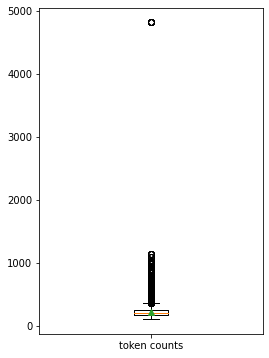

In [45]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)
plt.show()

7. answer Î∂ÑÏÑù

In [39]:
train_answer_starts = token_starts

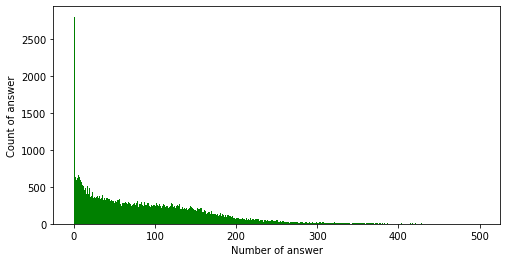

In [40]:
plt.figure(figsize=(8, 4))
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
plt.xlabel('Number of answer')
plt.ylabel('Count of answer')
plt.show()

In [41]:
describe("answer", train_answer_starts)

answer Í∏∏Ïù¥ ÏµúÎåÄ:    1124
answer Í∏∏Ïù¥ ÏµúÏÜå:       0
answer Í∏∏Ïù¥ ÌèâÍ∑†:      89.01
answer Í∏∏Ïù¥ ÌëúÏ§ÄÌé∏Ï∞®:   78.21
answer 25/100Î∂ÑÏúÑ:    25.00
answer 50/100Î∂ÑÏúÑ:    74.00
answer 75/100Î∂ÑÏúÑ:   134.00
answer IQR:         109.00
answer MAX/100Î∂ÑÏúÑ:  297.50


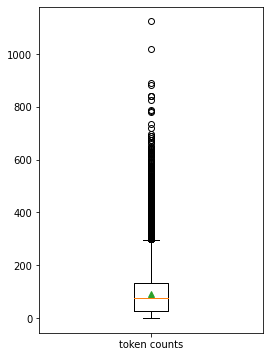

In [44]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

8. Word Cloud

In [43]:
documents = []

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú title, context, question Î¨∏Ïû•ÏùÑ Î™®Îëê Ï∂îÏ∂ú
for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

documents[:10]  

  0%|          | 0/1420 [00:00<?, ?it/s]

['ÌååÏö∞Ïä§Ìä∏_ÏÑúÍ≥°',
 '1839ÎÖÑ Î∞îÍ∑∏ÎÑàÎäî Í¥¥ÌÖåÏùò ÌååÏö∞Ïä§Ìä∏ÏùÑ Ï≤òÏùå ÏùΩÍ≥† Í∑∏ ÎÇ¥Ïö©Ïóê ÎßàÏùåÏù¥ ÎÅåÎ†§ Ïù¥Î•º ÏÜåÏû¨Î°ú Ìï¥ÏÑú ÌïòÎÇòÏùò ÍµêÌñ•Í≥°ÏùÑ Ïì∞Î†§Îäî ÎúªÏùÑ Í∞ñÎäîÎã§. Ïù¥ ÏãúÍ∏∞ Î∞îÍ∑∏ÎÑàÎäî 1838ÎÖÑÏóê Îπõ ÎèÖÏ¥âÏúºÎ°ú ÏÇ∞Ï†ÑÏàòÏ†ÑÏùÑ Îã§ Í±≤ÏùÄ ÏÉÅÌô©Ïù¥Îùº Ï¢åÏ†àÍ≥º Ïã§ÎßùÏóê Í∞ÄÎìùÌñàÏúºÎ©∞ Î©îÌîºÏä§ÌÜ†Ìé†Î†àÏä§Î•º ÎßåÎÇòÎäî ÌååÏö∞Ïä§Ìä∏Ïùò Ïã¨Í≤ΩÏóê Í≥µÍ∞êÌñàÎã§Í≥† ÌïúÎã§. ÎòêÌïú ÌååÎ¶¨ÏóêÏÑú ÏïÑÎ∏åÎÑ§ÌÅ¨Ïùò ÏßÄÌúòÎ°ú ÌååÎ¶¨ ÏùåÏïÖÏõê Í¥ÄÌòÑÏïÖÎã®Ïù¥ Ïó∞Ï£ºÌïòÎäî Î≤†ÌÜ†Î≤§Ïùò ÍµêÌñ•Í≥° 9Î≤àÏùÑ Îì£Í≥† ÍπäÏùÄ Í∞êÎ™ÖÏùÑ Î∞õÏïòÎäîÎç∞, Ïù¥Í≤ÉÏù¥ Ïù¥Îì¨Ìï¥ 1ÏõîÏóê ÌååÏö∞Ïä§Ìä∏Ïùò ÏÑúÍ≥°ÏúºÎ°ú Ïì∞Ïó¨ÏßÑ Ïù¥ ÏûëÌíàÏóê Ï°∞Í∏àÏù¥ÎùºÎèÑ ÏòÅÌñ•ÏùÑ ÎÅºÏ≥§ÏúºÎ¶¨ÎùºÎäî Í≤ÉÏùÄ ÏùòÏã¨Ìï† Ïó¨ÏßÄÍ∞Ä ÏóÜÎã§. Ïó¨Í∏∞Ïùò ÎùºÎã®Ï°∞ Ï°∞ÏÑ±Ïùò Í≤ΩÏö∞ÏóêÎèÑ Í∑∏Ïùò Ï†ÑÍ∏∞Ïóê Ï†ÅÌòÄ ÏûàÎäî Í≤ÉÏ≤òÎüº Îã®ÏàúÌïú Ï†ïÏã†Ï†Å ÌîºÎ°úÎÇò Ïã§ÏùòÍ∞Ä Î∞òÏòÅÎêú Í≤ÉÏù¥ ÏïÑÎãàÎùº Î≤†ÌÜ†Î≤§Ïùò Ìï©Ï∞ΩÍµêÌñ•Í≥° Ï°∞ÏÑ±Ïùò ÏòÅÌñ•ÏùÑ Î∞õÏùÄ Í≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§. Í∑∏Î†áÍ≤å ÍµêÌñ•Í≥° ÏûëÍ≥°ÏùÑ 1839ÎÖÑÎ∂ÄÌÑ

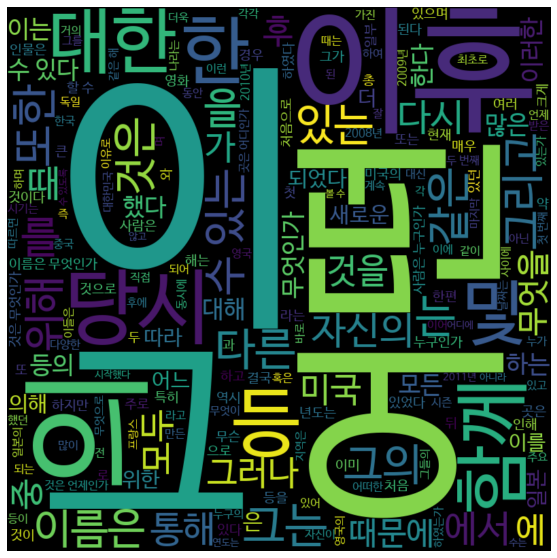

In [46]:
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(documents))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

9. Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [47]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [48]:
class Config(dict):
    """
    jsonÏùÑ config ÌòïÌÉúÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌïú Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})

In [51]:
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # ÏµúÎåÄ Í∏∏Ïù¥ÎÇ¥Ïóê tokenÏù¥ Îì§Ïñ¥Í∞ÄÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ Ï≤òÎ¶¨ÌïòÏßÄ ÏïäÏùå
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')
    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [53]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú Îç∞Ïù¥ÌÑ∞ÏÖã ÌôïÏù∏

In [54]:
# QuesitonÍ≥º ContextÍ∞Ä Ìè¨Ìï®
train_inputs[0][0]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,    10,

In [55]:
# Quesiton: 0, Context: 1Î°ú Íµ¨Î∂Ñ
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [57]:
# AnswerÏùò ÏãúÏûëÍ≥º ÎÅùÏ†ê(Ï≤´Î≤àÏß∏)
train_labels[0][0], train_labels[1][0]

(37, 37)

## BERT Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìïú Î¨∏Ï†ú ÌíÄÍ∏∞

![image](https://user-images.githubusercontent.com/63278762/133526948-934e3bfd-e8d2-4c98-a6ad-4c498a990156.png)

In [58]:
# Ïú†Ìã∏Î¶¨Ìã∞ Ìï®ÏàòÎì§

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask Í≥ÑÏÇ∞ÌïòÎäî Ìï®Ïàò
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask Í≥ÑÏÇ∞ÌïòÎäî Ìï®Ïàò
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation Ìï®Ïàò
    :param x: ÏûÖÎ†• Í∞í
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer ÏÉùÏÑ±
    :param stddev: ÏÉùÏÑ±Ìï† ÎûúÎç§ Î≥ÄÏàòÏùò ÌëúÏ§ÄÌé∏Ï∞®
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer ÏÉùÏÑ±
    """
    return tf.zeros_initializer


class Config(dict):
    """
    jsonÏùÑ config ÌòïÌÉúÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌïú Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        fileÏóêÏÑú ConfigÎ•º ÏÉùÏÑ± Ìï®
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [59]:
# mode == "embedding" Ïùº Í≤ΩÏö∞ Token Embedding Layer Î°ú ÏÇ¨Ïö©ÎêòÎäî layer ÌÅ¥ÎûòÏä§ÏûÖÎãàÎã§. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight ÏÉùÏÑ±
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        :param mode: Ïã§Ìñâ Î™®Îìú
        :return: embedding or linear Ïã§Ìñâ Í≤∞Í≥º
        """
        # modeÍ∞Ä embeddingÏùº Í≤ΩÏö∞ embedding lookup Ïã§Ìñâ
        if mode == "embedding":
            return self._embedding(inputs)
        # modeÍ∞Ä linearÏùº Í≤ΩÏö∞ linear Ïã§Ìñâ
        elif mode == "linear":
            return self._linear(inputs)
        # modeÍ∞Ä Í∏∞ÌÉÄÏùº Í≤ΩÏö∞ Ïò§Î•ò Î∞úÏÉù
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: ÏûÖÎ†•
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [60]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        :return embed: positional embedding lookup Í≤∞Í≥º
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [61]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        ÏÉùÏÑ±Ïûê
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer Ïã§Ìñâ
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: Ïã§Ìñâ Î™®Îìú
        :return attn_out: attention Ïã§Ìñâ Í≤∞Í≥º
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [62]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer Ïã§Ìñâ
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: Ïã§Ìñâ Î™®Îìú
        :return attn_out: attention Ïã§Ìñâ Í≤∞Í≥º
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [63]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: inputs
        :return ff_val: feed forward Ïã§Ìñâ Í≤∞Í≥º
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [64]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer Ïã§Ìñâ
        :param enc_embed: enc_embed ÎòêÎäî Ïù¥Ï†Ñ EncoderLayerÏùò Ï∂úÎ†•
        :param self_mask: enc_tokensÏùò pad mask
        :return enc_out: EncoderLayer Ïã§Ìñâ Í≤∞Í≥º
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [65]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer Ïã§Ìñâ
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS Í≤∞Í≥º logits
        :return logits_lm: LM Í≤∞Í≥º logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: ÏûÖÎ†• tokens
        :param segments: ÏûÖÎ†• segments
        :return embed: embedding Í≤∞Í≥º
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

KorQuADÏö©ÏúºÎ°ú finetuneÌïúÎã§.

In [66]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [70]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [67]:
bert_batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [71]:
model = BERT4KorQuAD(config)

In [72]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [73]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [78]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

history = {'train_acc':[], 'train_loss':[], 'val_acc':[], 'val_loss':[]}
best_acc = .0
patience = 0
for epoch in range(20):
    start_loss_train, end_loss_train, start_acc_train, end_acc_train = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    acc = start_acc_train + end_acc_train
    history['train_acc'].append(acc)
    loss = start_loss_train + end_loss_train
    history['train_loss'].append(loss)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    history['val_acc'].append(acc)
    loss = start_loss + end_loss
    history['val_loss'].append(loss)
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 3 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/3749 [00:00<?, ?it/s]

eval 0 >> loss: 5.9507, 5.9507, acc: 0.0026, 0.0032
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 1 >> loss: 5.9507, 5.9507, acc: 0.0039, 0.0032
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 2 >> loss: 5.9507, 5.9507, acc: 0.0033, 0.0046
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 3 >> loss: 5.9507, 5.9507, acc: 0.0035, 0.0037


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 4 >> loss: 5.9507, 5.9507, acc: 0.0033, 0.0047
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 5 >> loss: 5.9507, 5.9507, acc: 0.0042, 0.0032


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 6 >> loss: 5.9507, 5.9507, acc: 0.0018, 0.0035


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 7 >> loss: 5.9507, 5.9507, acc: 0.0018, 0.0039
early stopping


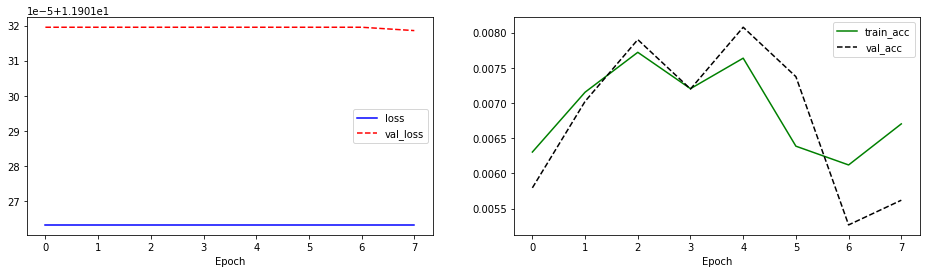

In [80]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'b-', label='loss')
plt.plot(history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'g-', label='train_acc')
plt.plot(history['val_acc'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 1. pretrained model Î°úÎî©ÌïòÍ∏∞

In [81]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model ÏùÑ Î°úÎìúÌïòÍ∏∞ ÏúÑÌï¥ Î®ºÏ†Ä Î™®Îç∏Ïù¥ ÏÉùÏÑ±ÎêòÏñ¥ ÏûàÏñ¥Ïïº ÌïúÎã§.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint ÌååÏùºÎ°úÎ∂ÄÌÑ∞ ÌïÑÏöîÌïú layerÎ•º Î∂àÎü¨Ïò®Îã§. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_73 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


## 2. pretrained model finetuneÌïòÍ∏∞

In [ ]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(20):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 3 <= patience:
        print(f'early stopping')
        break

## 3. Inference ÏàòÌñâÌïòÍ∏∞

In [82]:
def do_predict(model, question, context):
    """
    ÏûÖÎ†•Ïóê ÎåÄÌïú ÎãµÎ≥Ä ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò
    :param model: model
    :param question: ÏûÖÎ†• Î¨∏ÏûêÏó¥
    :param context: ÏûÖÎ†• Î¨∏ÏûêÏó¥
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [ ]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("ÏßàÎ¨∏ : ", question)
            print("ÏßÄÎ¨∏ : ", context)
            print("Ï†ïÎãµ : ", answer)
            print("ÏòàÏ∏° : ", answer_predict, "\n")
        if 100 < i:
            break